<a href="https://colab.research.google.com/github/josefernandezest98/training/blob/main/Change_Point_Detection/change_point_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Change Point Detection

In [2]:
!pip install ruptures

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 6.2 MB/s eta 0:00:00


In [3]:
import ruptures as rpt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

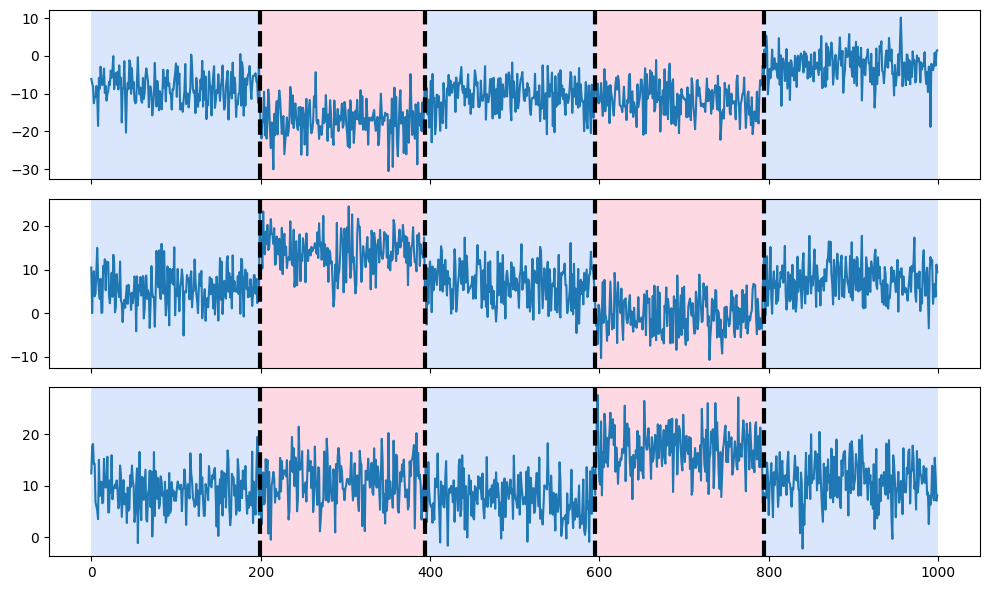

In [4]:
# generate signal
n_samples, dim, sigma = 1000, 3, 4
n_bkps = 4  # number of breakpoints
signal, bkps = rpt.pw_constant(n_samples, dim, n_bkps, noise_std=sigma)

# detection
model = rpt.Pelt(model="rbf")
model.fit(signal)

result = model.predict(pen=10)

# display
rpt.display(signal, bkps, result)
plt.show()

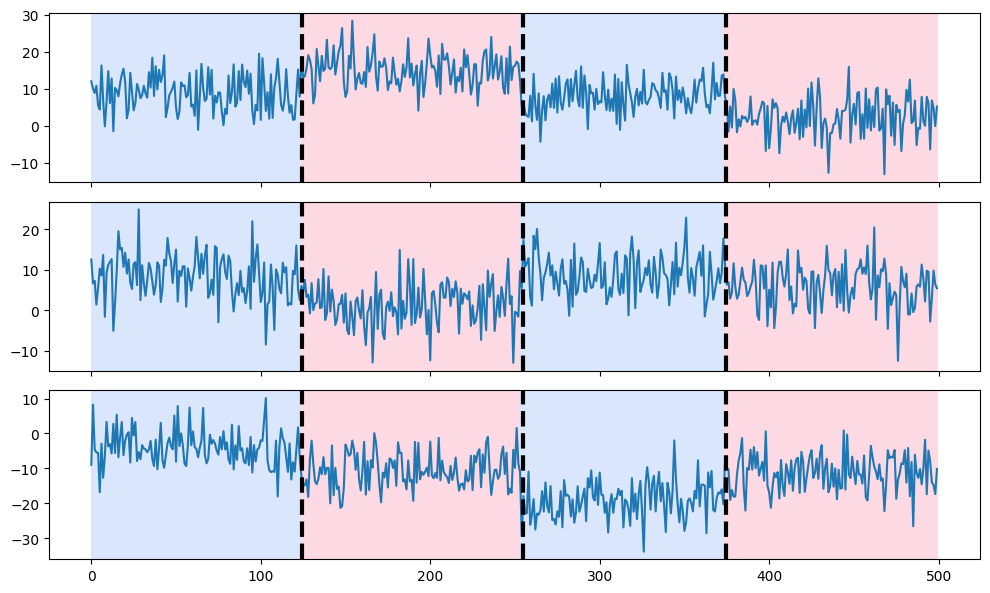

In [5]:
# creation of data
n, dim = 500, 3
n_bkps, sigma = 3, 5
signal, bkps = rpt.pw_constant(n, dim, n_bkps, noise_std=sigma)

# change point detection
model = "l1"  # "l2", "rbf"
algo = rpt.Dynp(model=model, min_size=3, jump=5).fit(signal)
my_bkps = algo.predict(n_bkps=3)

# show results
rpt.show.display(signal, bkps, my_bkps, figsize=(10, 6))
plt.show()